
# Prepare ReCON Webcam Images for Optical Wave Gauging

This code was written by [Nicholas Catanzaro](https://github.com/ncata/GLERL_contract) for NOAA GLERL 



##### Functionality
This notebook is a work in progress. It contains code for functions that will be put into a .py file. It is arranged to walk the reader through the author's logic and allow a variety of people who may be unfamiliar with the OWG or Jupyter to implement the code. 


In [1]:
# import packages and libs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
import calendar
import os
import shutil
import csv
import pytz
from PIL import Image
from distutils.dir_util import copy_tree



### Augment and QC Images

Images need to be taken from a directory and then sorted, augmented, and QC'd. This code copies images to new folders based on camera view, and then modifies them to a lower resolution, square, grayscale image that only contains water. Images that are bright enough to reasonably assume they were not taken at night are then kept in the output directory  

In [12]:
def prepowgimgs(year, directory, arrayshape, resolution, trial, viewlist):
    '''Create a new directory for images in each view and run QC and primary augmentation before interpolation and then model 
    training, validation, or testing. version 2.5
    
    Year: the target year of images, 
    directory: where the year files are stored,
    resolution:the resolution the images will be reduced to, 
    trial: the name of the trial that these inputs are associated with. 
    viewlist: a list of the view numbers found in the target year folder
    '''
    start = time.time()
    #set counters 
    counter = 0
    nightcounter = 0
    failcounter = 0
    
    # create a new directory for images
    foldername = "/{}_imgprep".format(str(year))
    newdir = directory+foldername+"{}".format(trial)
    try:
        shutil.rmtree(newdir)
        print("Folder found: deleting contents")
        print("Creating folder")
        os.mkdir(newdir)
    except:
        print("Creating folder")
        #os.mkdir(newdir)

    # copy files into new directory, this can take a while
    # Write code that will make sure only imgaes get copied, not other past directories
    print("Moving Files")
    copy_tree(directory, newdir)
    
    # seperate the views into different folders within the directory
    viewdirs = []
    for view in viewlist:
        print("Seperating View {}".format(view))
        viewpath = newdir+"/view{}".format(view)
        viewdirs.append(viewpath)
        os.mkdir(viewpath) 
    
    
    for viewpath in viewdirs:
        print ("Moving images to {}".format(viewpath))
        # move images into views
        for filename in os.listdir(newdir):
            if filename[-5] == viewpath[-1]:
                os.rename(newdir+"/{}".format(filename), viewpath+"/{}".format(filename.replace(filename[13:16],"")))   
        
        # edit images from desired view into cropped lower resolution grayscale and store in new folder
        print ("Augmenting and filtering imgaes in {}".format(viewpath))
        for filename in os.listdir(viewpath):
            if filename.endswith(".jpg"):
                image = Image.open(viewpath+"/{}".format(filename)).convert("L")
            
                # select target portion of image to make it square
                bwarray = np.array(image) 
                small = bwarray[arrayshape]
                
                # change image resoltuion
                img = Image.fromarray(small)
                resize = (resolution, resolution)
                smaller = img.resize(resize)
               
                #Get QC metrics
                avgintensity = np.mean(np.asarray(smaller))
                
                # perform QC
                if avgintensity < 85:
                    os.remove(viewpath+"/"+filename)
                    failcounter = failcounter + 1
                else:
                    # save images to OWG directory
                    try:
                        counter = counter + 1
                        owgimage = smaller.save(viewpath+"/{}".format(filename))
                    except IOError:
                        print("cannot create image for", filename)
                        failcounter = failcounter + 1
        
                    # remove the underscore in the filename
                    os.rename(viewpath+"/"+filename, viewpath+"/"+filename.replace("_",""))
                    
    print (failcounter, "images removed for quality control")
    print (counter, "images processed")
    end = time.time()   
    
    return print ("Completed in {} minutes.".format((end - start)/60))

In [13]:
# code to move images? or incorporate into function?

# Prepare a CSV file for the OWG


## Read data

Data comes from two sources:  
* 1. NDBC standard meteorlogical observation archives, found [here](https://www.ndbc.noaa.gov/) 
* 2. Archived ReCON imagery, partial records can be scraped from the [website](https://www.glerl.noaa.gov/metdata/) or accessed from GLERL's network. These images should have been processed by the prepowgimgs function


This data must be joined so that each webcam image is associated with the meterological observations taken no later than 30 minutes before or after the image was captured.

In [3]:
# Complete csv

def waveframetocsv(fn, target, csvfile, directory, localtimezone):
    '''
    This function takes a txt file and folder of OWG images and combines the data into a csv file that can be fed into the OWG. 
    version 2.0
    
    fn: filename and location of .txt file
    target: attribute that the owg will be predicting
    csvfile:the name of the csvfile being created
    directory: the directory of images that have been prepped for OWG filtering
    localtimezone: the timezone code in pytz that the images were taken in
    '''
    
    #counters for debugging and perfomance info
    initaladdcounter = 0
    rangecounter = 0
    successcounter = 0
    failcounter = 0
    timecounter = 0
    outofrangecounter = 0
    
    # create a dataframe from the buoy data
    df = pd.read_csv(fn, skiprows=range(1,2), delim_whitespace = True, \
                    parse_dates={'date':[0,1,2,3,4]}, keep_date_col=False)

    # Transfer data in "date" column to a column where it is stored as a datetime object
    df['datetime'] = pd.to_datetime(df['date'], format = '%Y %m %d %H %M',utc=True)
    df = df.drop(df.columns[[0,1,2,3,6,8,9,10,11,12, 13]], axis = 1)
    
    # calculate unix datetime
    df['epoch']=(df['datetime'] - pd.Timestamp("1970-01-01",tz='utc')) // pd.Timedelta('1s')
    
    print(df)
    
    # delete the csv file if it exsists
    try:
        print ("Overwriting csv file")
        os.remove(csvfile)
        owgframe = pd.DataFrame({"id":[], "H":[], "T":[], "MWDIR":[]})
    except:
        print("couldn't find file, making new one")
        # create csv file that will be appended to by loop
        owgframe = pd.DataFrame({"id":[], "H":[], "T":[], "MWDIR":[]})

    #loop through directory and extract unix timestamp
    for filename in os.listdir(directory):
        # Use string slicing to remove .jpg from filename
        size = len(filename)
        fn = filename[:size - 4]
       
        
        #get utc time from filename
        local = pytz.timezone(localtimezone)
        naive = datetime.datetime.strptime(fn, "%Y%m%d%H%M")
        local_dt = local.localize(naive)
        utc_dt = local_dt.astimezone(pytz.utc)
        utime = calendar.timegm(utc_dt.timetuple())
        
        # combine datasets
        try:
            # track if buoy was in the water when the image was taken and find the closest record
            if utime >= df['epoch'].iat[0]:
                result_index = df['epoch'].sub(utime).abs().idxmin()
                result = df['epoch'].iat[result_index]
                rangecounter = rangecounter + 1
                
                # determine if the closest record was within 30 minutes and add to final dataframe
                if abs(utime - result) <= 1800:
                    initaladdcounter = initaladdcounter + 1
                    stageframe = {"id":filename, "H": df['WVHT'].iat[result_index], "T": df['DPD'].iat[result_index], "MWDIR":df['MWD'].iat[result_index]}
                    owgframe = owgframe.append(stageframe, ignore_index = True)
                    
                    # drop NAN values for the target variable
                    if target == "WVHT":
                        owgframe = owgframe[owgframe.H != 99.0]
                    if target == "DPD":
                        owgframe = owgframe[owgframe.DPD != 99.0]
                    if target == "MWD":
                        owgframe = owgframe[owgframe.MWDIR != 999]
                else:
                    timecounter = timecounter + 1
            else:
                outofrangecounter = outofrangecounter + 1
        except:
            failcounter = failcounter + 1
    
    # write final dataframe to csv
    added = len(owgframe.index)
    owgframe.to_csv(csvfile, index = False)    
    
    # display performance information
    print ("you have {} images during buoy deployment".format(rangecounter))
    print ("{} images outside of buoy deployment".format(outofrangecounter))
    print ("{} images do not have data within 30 minutes".format(timecounter))
    print ("{} images had NAN data from buoy".format(initaladdcounter-int(added)))
    print ("{} images failed".format(failcounter))
    print ("{} images added to {}".format(added, csvfile))
    
   
    
    return  
                   


### Merging multiple datasets 

If you want to use multiple years, you will need to merge the csv files together with the below function before continuing


In [4]:
def mergeyears(csv_directory, startswith, mergedcsv):
    ''' Merges multiple csv files together into one cohesive dataset that can be used for optical wave gauging. 
    csv file names must have identical beginnings for this function to work. 
    
    csv_direcotry: folder with all target csv files
    startswith: string that comprises the beginning of all target file names
    mergedcsv: name of the csv file to be created '''
    
    filelist = [csv_directory + file for file in os.listdir(csv_directory) if file.startswith(startswith)]
    csv_list = []
    for file in sorted(filelist):
        csv_list.append(pd.read_csv(file, sep = ","))
    csv_merged = pd.concat(csv_list, ignore_index = True)
    
    csv_merged.to_csv(csv_directory + mergedcsv, index = False)
    
    return print ("csv with {} rows created".format(len(csv_merged)))


### Code for creating model assessment dataset

The OWG requires data to train the model, which is then split up into train and validation datasets, and also data for model assessment. Since the model can not be assessed with data it has seen before, we need to randomly drop out a percentage of the dataset so that it is not used for training. 

In [5]:
def sample_ran(csv, sample_csv, sample_percent):
    ''' This function selects for a percentage of random rows in the csv training dataset 
    and creates a new csv for model assessment while dropping them from the original csv
    
    csv : Path to the csv that the function initially reads
    validation_csv : Path and name of the csv to be created from csv
    sample_percent : decimal value of the percentage of rows to be sampled '''
    
    if os.path.exists(sample_csv) == True:
        return print ("File already exists")
    else:    
        # open csv as a pandas dataframe 
        df = pd.read_csv(csv, sep = ",")
        # randomly sample data
        df_sample = df.sample(n = int(sample_percent * len(df.index)))
        # drop data from original dataframe that has been sampled
        df = df[~df.id.isin(df_sample.id)]
   
        # export dataframes as csv files
        df.to_csv(csv, sep = ",", index = False) 
        df_sample.to_csv(sample_csv, sep = ",", index = False)
        print ("writing {}".format(sample_csv))
    
        return print ("{}% of {} ({} rows) sampled".format(sample_percent*100, csv, len(df_sample)))


### Run Code

In [ ]:
# prep your images

year =
directory = 
arrayshape =  
resolution = 
trial = 
viewlist = 

prepowgimgs(year, directory, arrayshape, resolution, trial, viewlist)

In [ ]:
# create a csv file

fn = 
target = 
csvfile = 
directory = 
localtimezone = 

waveframetocsv(fn, target, csvfile, directory, localtimezone)

In [ ]:
# optional merge multiple csv files

csv_directory = 
startswith = 
mergedcsv = 

mergeyears(csv_directory, startswith, mergedcsv)

In [ ]:
# separate the data into train and test sets

csv = 
sample_csv =
sample_percent = 

sample_ran(csv, sample_csv, sample_percent)

In [22]:
year = 2021
directory = "C:/njc/misc/mcy"
arrayshape =  np.index_exp[310:1280, 310:1280]
resolution = 512 
trial = "glerl3" 
viewlist = [1,2,3]

prepowgimgs(year, directory, arrayshape, resolution, trial, viewlist)
prepowgimgs

Creating folder
Moving Files
Seperating View 1
Seperating View 2
Seperating View 3
Moving images to C:/njc/misc/mcy/2021_imgprepglerl3/view1
Augmenting and filtering imgaes in C:/njc/misc/mcy/2021_imgprepglerl3/view1
Moving images to C:/njc/misc/mcy/2021_imgprepglerl3/view2
Augmenting and filtering imgaes in C:/njc/misc/mcy/2021_imgprepglerl3/view2
Moving images to C:/njc/misc/mcy/2021_imgprepglerl3/view3
Augmenting and filtering imgaes in C:/njc/misc/mcy/2021_imgprepglerl3/view3
1859 images removed for quality control
7530 images processed
Completed in 9.56841758886973 minutes.


<function __main__.prepowgimgs(year, directory, arrayshape, resolution, trial, viewlist)>

In [6]:
year = 2020
directory = "D:/ReCON_imgs/2020/mcy"
arrayshape =  np.index_exp[310:1280, 310:1280]
resolution = 512 
trial = "glerl3" 
viewlist = [1,2]

prepowgimgs(year, directory, arrayshape, resolution, trial, viewlist)


Creating folder
Moving Files
Seperating View 1
Seperating View 2
Moving images to D:/ReCON_imgs/2020/mcy/2020_imgprepglerl3/view1
Augmenting and filtering imgaes in D:/ReCON_imgs/2020/mcy/2020_imgprepglerl3/view1
Moving images to D:/ReCON_imgs/2020/mcy/2020_imgprepglerl3/view2
Augmenting and filtering imgaes in D:/ReCON_imgs/2020/mcy/2020_imgprepglerl3/view2
2332 images removed for quality control
3388 images processed
Completed in 5.2512319127718605 minutes.


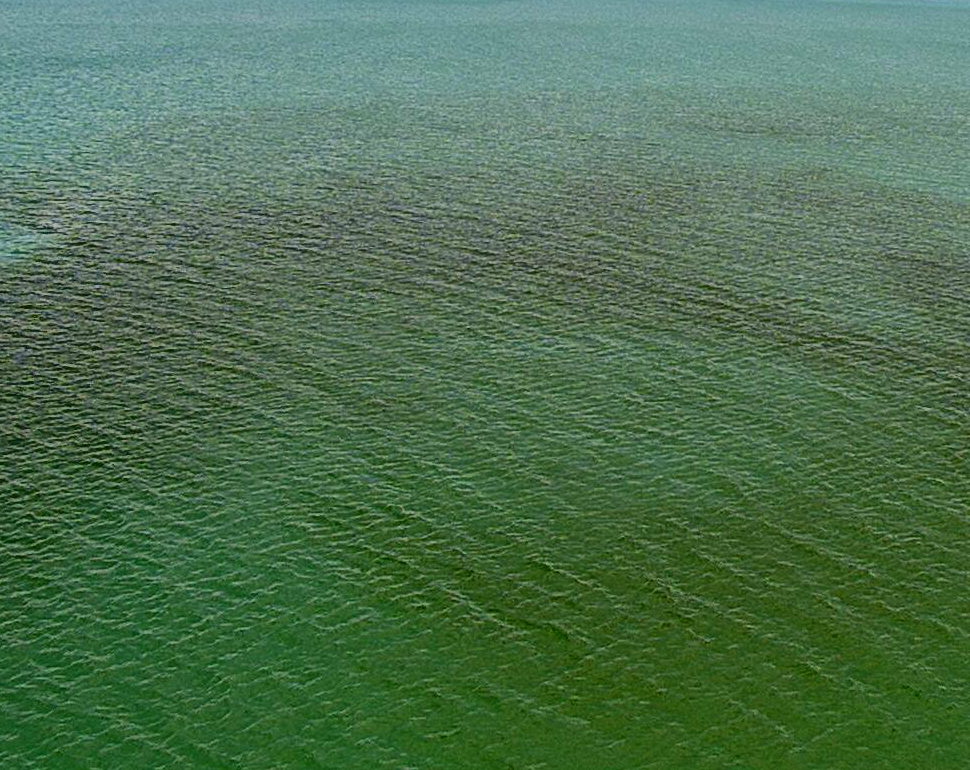

In [21]:
img = "C:/njc/misc/mcy/20210407_1533.02.jpg"
array = np.asarray(Image.open(img))
array = array[310:1280, 310:1280]
Image.fromarray(array)

In [11]:
csv = "D:/GLERL/owg_files/glerl2/owg_glerl2.csv"
sample_csv = "D:/GLERL/owg_files/glerl2/owg_glerl2_sample.csv"
sample_percent = .3
sample_ran(csv, sample_csv, sample_percent)

writing D:/GLERL/owg_files/glerl2/owg_glerl2_sample.csv
30.0% of D:/GLERL/owg_files/glerl2/owg_glerl2.csv (588 rows) sampled


In [3]:
year = 2021
directory = "C:/njc/misc/mcy"
arrayshape =  np.index_exp[100:1000, 100:1000]
resolution = 256 
trial = "glerl2" 
viewlist = [1,2,3]

prepowgimgs(year, directory, arrayshape, resolution, trial, viewlist)

Creating folder
Moving Files
Seperating View 1
Seperating View 2
Seperating View 3
Moving images to C:/njc/misc/mcy/2021_imgprepglerl2/view1
Augmenting and filtering imgaes in C:/njc/misc/mcy/2021_imgprepglerl2/view1
Moving images to C:/njc/misc/mcy/2021_imgprepglerl2/view2
Augmenting and filtering imgaes in C:/njc/misc/mcy/2021_imgprepglerl2/view2
Moving images to C:/njc/misc/mcy/2021_imgprepglerl2/view3
Augmenting and filtering imgaes in C:/njc/misc/mcy/2021_imgprepglerl2/view3
650 images removed for quality control
8739 images processed
Completed in 17.334051462014518 minutes.


In [7]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2021.txt"
target = "WVHT"
csvfile = "D:/GLERL/owg_files/glerl3/owg_glerl3.csv"
directory = "C:/njc/misc/mcy/2021_imgprepglerl3/view2"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.41   2.68   24 2021-05-08 22:00:00+00:00  1620511200
1      0.39   2.78   63 2021-05-08 22:10:00+00:00  1620511800
2      0.39   2.45   65 2021-05-08 22:20:00+00:00  1620512400
3      0.36   2.62   84 2021-05-08 22:30:00+00:00  1620513000
4      0.34   2.73   86 2021-05-08 22:40:00+00:00  1620513600
...     ...    ...  ...                       ...         ...
20897  0.28   2.11  224 2021-10-14 11:30:00+00:00  1634211000
20898  0.27   2.33  217 2021-10-14 11:40:00+00:00  1634211600
20899  0.25   2.32  215 2021-10-14 11:50:00+00:00  1634212200
20900  0.23   2.34  227 2021-10-14 12:10:00+00:00  1634213400
20901  0.23  99.00  216 2021-10-14 12:20:00+00:00  1634214000

[20902 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 1859 images during buoy deployment
261 images outside of buoy deployment
233 images do not have data within 30 minutes
68 images had NAN data from buoy
0 images fail

In [8]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2020.txt"
target = "WVHT"
csvfile = "D:/GLERL/owg_files/glerl3/owg_glerl3_2020.csv"
directory = "D:/ReCON_imgs/2020/mcy/2020_imgprepglerl3/view2"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

      WVHT    DPD  MWD                  datetime       epoch
0     0.59  99.00  999 2020-06-15 20:00:00+00:00  1592251200
1     0.66  99.00  999 2020-06-15 20:10:00+00:00  1592251800
2     0.66  99.00  299 2020-06-15 20:20:00+00:00  1592252400
3     0.70  99.00  999 2020-06-15 20:30:00+00:00  1592253000
4     0.63   7.82   20 2020-06-15 20:50:00+00:00  1592254200
...    ...    ...  ...                       ...         ...
6488  0.66   3.30  120 2020-08-14 04:10:00+00:00  1597378200
6489  0.66   3.38   41 2020-08-14 04:20:00+00:00  1597378800
6490  0.67   3.38  999 2020-08-14 04:30:00+00:00  1597379400
6491  0.74   3.38  999 2020-08-14 04:40:00+00:00  1597380000
6492  0.78   3.38   41 2020-08-14 04:50:00+00:00  1597380600

[6493 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 695 images during buoy deployment
1071 images outside of buoy deployment
460 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images failed
235 images 

In [9]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2019.txt"
target = "WVHT"
csvfile =  "D:/GLERL/owg_files/glerl3/owg_glerl3_2019.csv"
directory = "D:/ReCON_imgs/2019/mcy/2019_imgprepglerl3/view2"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.00  99.00  999 2019-04-02 19:00:00+00:00  1554231600
1      0.00   5.45   67 2019-04-02 19:10:00+00:00  1554232200
2      0.00   6.83  235 2019-04-02 19:20:00+00:00  1554232800
3      0.46   2.41  191 2019-04-17 23:00:00+00:00  1555542000
4      0.45   2.39  206 2019-04-17 23:10:00+00:00  1555542600
...     ...    ...  ...                       ...         ...
28512  0.48   2.21   41 2019-11-06 15:20:00+00:00  1573053600
28513  0.49   2.21   77 2019-11-06 15:30:00+00:00  1573054200
28514  0.51   2.21  118 2019-11-06 15:40:00+00:00  1573054800
28515  0.51   2.26  212 2019-11-06 15:50:00+00:00  1573055400
28516  0.48   2.38  192 2019-11-06 16:00:00+00:00  1573056000

[28517 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 1391 images during buoy deployment
169 images outside of buoy deployment
375 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images faile

In [12]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2018.txt"
target = "WVHT"
csvfile = "C:/njc/src/GLERL_contract/buoy_data/mcy_glerl1_2018.csv"
directory = "D:/ReCON_imgs/mcy_total/2018"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.26   4.13   95 2018-05-07 20:20:00+00:00  1525724400
1      0.25   4.03  343 2018-05-07 20:30:00+00:00  1525725000
2      0.25   4.08  329 2018-05-07 20:40:00+00:00  1525725600
3      0.25   4.10   12 2018-05-07 20:50:00+00:00  1525726200
4      0.25   4.15  206 2018-05-07 21:00:00+00:00  1525726800
...     ...    ...  ...                       ...         ...
25649  0.71   3.47  292 2018-11-05 17:10:00+00:00  1541437800
25650  0.45   3.47  999 2018-11-05 17:20:00+00:00  1541438400
25651  0.00  99.00  999 2018-11-09 20:20:00+00:00  1541794800
25652  0.01   7.01   64 2018-11-09 20:30:00+00:00  1541795400
25653  0.00  99.00  999 2018-11-09 21:30:00+00:00  1541799000

[25654 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 2198 images during buoy deployment
1308 images outside of buoy deployment
222 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images fail

In [15]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2017.txt"
target = "WVHT"
csvfile = "C:/njc/src/GLERL_contract/buoy_data/mcy_glerl1_2017.csv"
directory = "D:/ReCON_imgs/2017/mcy/2017_imgprepglerl1/view2"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.01  11.64  999 2017-04-19 18:10:00+00:00  1492625400
1      0.01  99.00  999 2017-04-19 18:20:00+00:00  1492626000
2      0.01  12.15   45 2017-04-19 18:30:00+00:00  1492626600
3      0.01  10.41   40 2017-04-19 18:40:00+00:00  1492627200
4      0.01   6.58  227 2017-04-19 18:50:00+00:00  1492627800
...     ...    ...  ...                       ...         ...
27893  0.70   2.29   66 2017-11-11 17:00:00+00:00  1510419600
27894  0.92   2.29  999 2017-11-11 17:10:00+00:00  1510420200
27895  0.91   2.29  999 2017-11-11 17:20:00+00:00  1510420800
27896  0.72   2.29   61 2017-11-11 17:30:00+00:00  1510421400
27897  0.42   2.29  263 2017-11-11 17:40:00+00:00  1510422000

[27898 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 2601 images during buoy deployment
498 images outside of buoy deployment
521 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images faile

In [16]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2016.txt"
target = "WVHT"
csvfile = "C:/njc/src/GLERL_contract/buoy_data/mcy_glerl1_2016.csv"
directory = "D:/ReCON_imgs/mcy_total/2016"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.00  99.00  999 2016-05-06 14:10:00+00:00  1462543800
1      0.00   8.26  999 2016-05-06 14:20:00+00:00  1462544400
2      0.01  10.45  999 2016-05-06 14:30:00+00:00  1462545000
3      0.01  12.76  999 2016-05-06 14:40:00+00:00  1462545600
4      0.01  10.75  312 2016-05-06 14:50:00+00:00  1462546200
...     ...    ...  ...                       ...         ...
25051  0.40   3.96  999 2016-11-01 17:00:00+00:00  1478019600
25052  0.41   4.40   70 2016-11-01 17:10:00+00:00  1478020200
25053  0.44   4.40  208 2016-11-01 17:20:00+00:00  1478020800
25054  0.39   5.63  267 2016-11-01 17:30:00+00:00  1478021400
25055  0.27   4.76  284 2016-11-01 17:40:00+00:00  1478022000

[25056 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 2175 images during buoy deployment
163 images outside of buoy deployment
370 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images faile

In [17]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2015.txt"
target = "WVHT"
csvfile = "C:/njc/src/GLERL_contract/buoy_data/mcy_glerl1_2015.csv"
directory = "D:/ReCON_imgs/mcy_total/2015"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.02  99.00  999 2015-04-16 16:00:00+00:00  1429200000
1      0.01   5.89  244 2015-04-16 16:10:00+00:00  1429200600
2      0.01   5.89   81 2015-04-16 16:20:00+00:00  1429201200
3      0.01   6.55   13 2015-04-16 16:30:00+00:00  1429201800
4      0.01   6.55  999 2015-04-16 16:40:00+00:00  1429202400
...     ...    ...  ...                       ...         ...
28406  0.31   2.71  241 2015-11-02 18:30:00+00:00  1446489000
28407  0.33   2.71  999 2015-11-02 18:40:00+00:00  1446489600
28408  0.35   2.80  271 2015-11-02 18:50:00+00:00  1446490200
28409  0.50   2.80  999 2015-11-02 19:00:00+00:00  1446490800
28410  0.54   2.80  999 2015-11-02 19:10:00+00:00  1446491400

[28411 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 2076 images during buoy deployment
90 images outside of buoy deployment
579 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images failed

In [18]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2014.txt"
target = "WVHT"
csvfile = "C:/njc/src/GLERL_contract/buoy_data/mcy_glerl1_2014.csv"
directory = "D:/ReCON_imgs/mcy_total/2014"
localtimezone = "America/Chicago"

waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT   DPD  MWD                  datetime       epoch
0      0.28  3.44    2 2014-06-10 14:40:00+00:00  1402411200
1      0.30  3.26   10 2014-06-10 14:50:00+00:00  1402411800
2      0.29  3.17    4 2014-06-10 15:00:00+00:00  1402412400
3      0.30  3.15   11 2014-06-10 15:10:00+00:00  1402413000
4      0.28  3.21  353 2014-06-10 15:20:00+00:00  1402413600
...     ...   ...  ...                       ...         ...
17463  0.96  1.75  999 2014-10-10 15:50:00+00:00  1412956200
17464  0.95  1.75  999 2014-10-10 16:00:00+00:00  1412956800
17465  1.05  1.75  343 2014-10-10 16:10:00+00:00  1412957400
17466  1.12  1.75  999 2014-10-10 16:20:00+00:00  1412958000
17467  2.07  1.75  999 2014-10-10 16:30:00+00:00  1412958600

[17468 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 694 images during buoy deployment
672 images outside of buoy deployment
149 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images failed
545 images 

In [19]:
fn = "C:/njc/src/GLERL_contract/buoy_data/mcy2013.txt"
target = "WVHT"
csvfile = "C:/njc/src/GLERL_contract/buoy_data/mcy_glerl1_2013.csv"
directory = "D:/ReCON_imgs/mcy_total/2013"
localtimezone = "America/Chicago"
waveframetocsv(fn, target, csvfile, directory, localtimezone)

       WVHT    DPD  MWD                  datetime       epoch
0      0.41  99.00  273 2013-06-01 00:00:00+00:00  1370044800
1      0.37   2.02  182 2013-06-01 00:10:00+00:00  1370045400
2      0.33   2.12  199 2013-06-01 00:20:00+00:00  1370046000
3      0.29   2.12   -1 2013-06-01 00:30:00+00:00  1370046600
4      0.28   2.12   -1 2013-06-01 00:40:00+00:00  1370047200
...     ...    ...  ...                       ...         ...
21723  0.12  99.00  139 2013-10-30 17:50:00+00:00  1383155400
21724  0.25  99.00  134 2013-10-30 18:00:00+00:00  1383156000
21725  0.47  99.00  188 2013-10-30 18:10:00+00:00  1383156600
21726  0.42  99.00  330 2013-10-30 18:20:00+00:00  1383157200
21727  0.01  99.00   -1 2013-10-30 18:30:00+00:00  1383157800

[21728 rows x 5 columns]
Overwriting csv file
couldn't find file, making new one
you have 1288 images during buoy deployment
0 images outside of buoy deployment
309 images do not have data within 30 minutes
0 images had NAN data from buoy
0 images failed


In [10]:
csv_directory = "D:/GLERL/owg_files/glerl3/"
startswith = "owg_glerl3"
mergedcsv = "owg_glerl3.csv"
mergeyears(csv_directory, startswith, mergedcsv)

csv with 2809 rows created


In [11]:
csv = "D:/GLERL/owg_files/glerl3/owg_glerl3.csv"
sample_csv = "D:/GLERL/owg_files/glerl3/owg_glerl3_sample.csv"
sample_percent = .3
sample_ran(csv, sample_csv, sample_percent)

writing D:/GLERL/owg_files/glerl3/owg_glerl3_sample.csv
30.0% of D:/GLERL/owg_files/glerl3/owg_glerl3.csv (842 rows) sampled
